### Keras의 Image classification from scratch를 참고하였습니다.

https://keras.io/examples/vision/image_classification_from_scratch/

kaggle의 **cats and dogs** 데이터셋을 다운로드한다.

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   141M      0  0:00:05  0:00:05 --:--:--  142M


In [ ]:
!ls

kagglecatsanddogs_5340.zip  sample_data


In [ ]:
!unzip kagglecatsanddogs_5340.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: P

압축을 풀면 PetImages 폴더가 생성된 것을 확인할 수 있다.

코랩을 사용하고 있다면 좌측의 **파일** 카테고리를 눌러보면 파일이 다운받아진 것을 알 수 있다.

In [ ]:
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [ ]:
!ls PetImages

Cat  Dog


이제, 손상된 이미지 파일이나 JPEG 압축 방식이 아닌 파일을 제거한다.

In [ ]:
import os
import numpy as np

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            os.remove(fpath)

다운받은 이미지를 살펴보면, 각 이미지의 크기가 서로 다른것을 알 수 있다.

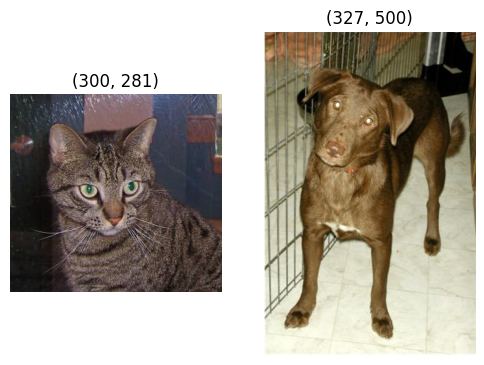

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

cat = Image.open('/content/PetImages/Cat/1.jpg')
dog = Image.open('/content/PetImages/Dog/1.jpg')

plt.figure(figsize = (6 ,6))

plt.subplot(1, 2, 1)
plt.imshow(cat)
plt.title(cat.size)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dog)
plt.title(dog.size)
plt.axis('off')

plt.show()

훈련용 데이터와 검증용 데이터를 분리한다. 앞서 이미지가 서로 다른 크기인 것을 확인하였으므로 이미지의 크기도 지정해준다.

In [ ]:
import keras

# image_dataset_from_directory : 경로로부터 이미지를 불러와 데이터셋(tf.data.Dataset)을 만들어주는 모듈

train, valid = keras.utils.image_dataset_from_directory(
    '/content/PetImages',
    batch_size = 128,         # 배치 크기 지정, tf.data.Dataset은 데이터셋에서부터 배치 크기를 지정할 수 있음
    image_size = (180, 180),  # 이미지의 크기 지정
    seed = 42,
    validation_split = 0.2,   # 검증셋 비율
    subset = 'both',          # subset = 'both'로 지정 시 return 값은 훈련셋, 검증셋 두 개의 튜플임. 단, validation_split을 지정한 경우에만 사용 가능
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


image_dataset_from_directory 처럼 폴더로부터 데이터셋을 만들어내는 케라스의 모듈의 경우 주의가 필요하다.

반드시 아래와 같은 형태의 구조를 가지고 있어야 한다.



```
/맨 위 디렉토리
  /하위 디렉토리 (클래스 1)
    /파일1.jpg
    /파일2.jpg
    ...
  /하위 디렉토리 (클래스 2)
    /파일1.jpg
    /파일2.jpg
    ...
  ...
```

In [ ]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
valid

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

데이터가 잘 섞였는지 확인해보자.

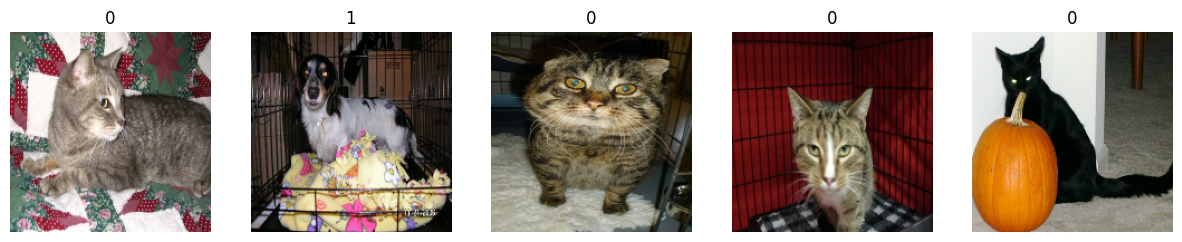

In [ ]:
plt.figure(figsize = (15, 5))

for images, labels in train.take(5):  # take() 메소드는 tf.data.Dataset 형식의 데이터셋에서 지정한 개수만큼 앞에서부터 가져옴. 이터레이션 형식으로 동작. 처음 실행 시 1 ~ 5번 이미지, 다음 실행 시 6 ~ 10번 이미지를 가져옴.
  for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')

plt.show()

훈련셋 데이터의 양이 증가하면 모델의 성능이 더 좋아질 수 있다.

이미지 데이터의 경우 반전, 이동, 회전 등을 이용해 데이터가 늘어나는 효과를 만들 수 있다. 또한 이렇게 데이터의 양이 증가하면 과대적합의 위험성도 감소한다.

이것을 **데이터 증강(Data Augmentation)**이라고 한다.

In [ ]:
from keras import layers

layers.RandomFlip('horizontal') # 이미지 좌우 반전
layers.RandomRotation(0.1)  # 이미지 회전, 여기서는 시계 또는 반시계

# 이 외에도 RandomZoom, RandomTranslation 등이 있음

<RandomRotation name=random_rotation, built=False>

이미지를 하나 가져와 확인해보자.

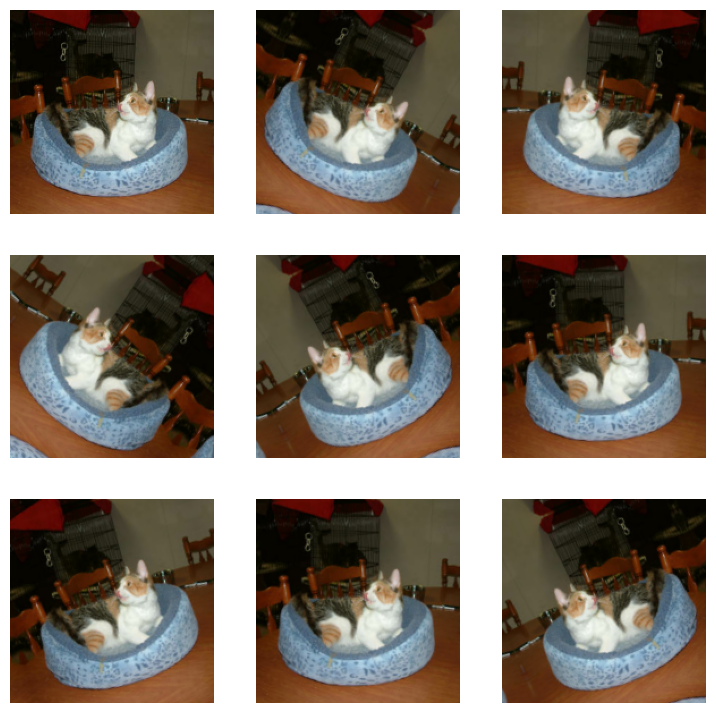

In [ ]:
plt.figure(figsize = (9, 9))

for image, _ in train.take(1):
  plt.subplot(3, 3, 1)
  plt.imshow(np.array(image[0]).astype('uint8')) # 좌측 상단 이미지 : 원본 이미지
  plt.axis('off')

  for i in range(8):
    x = layers.RandomFlip('horizontal')(image)
    x = layers.RandomRotation(0.1)(x)

    plt.subplot(3, 3, i + 2)
    plt.imshow(np.array(x[0]).astype('uint8'))
    plt.axis('off')

plt.show()

이제 모델을 생성한다.

In [ ]:
inputs = keras.Input(shape = (180, 180, 3))

x = layers.RandomFlip('horizontal')(inputs)
x = layers.RandomRotation(0.1)(x)

x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

residual = x

for filter_size in [256, 512, 728]:
  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(filter_size, kernel_size = 3, padding = 'same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(filter_size, kernel_size = 3, padding = 'same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.MaxPooling2D(pool_size = 3, strides = 2, padding = 'same')(x)

  residual = layers.Conv2D(filter_size, kernel_size = 1, strides = 2, padding = 'same')(residual)
  x = layers.add([x, residual])
  residual = x

x = layers.SeparableConv2D(filters = 1024, kernel_size = 3, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.25)(x)

outputs = layers.Dense(1, activation = 'sigmoid')(x)

In [ ]:
model = keras.Model(inputs = inputs, outputs = outputs)

모델의 전체 구조와 파라미터 수를 확인하면 다음과 같다. 별명을 따로 붙히지 않았기 때문에 잔차(Residual) 연결 시 어디와 이어져있는지 확인이 조금 어렵다.

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip_39            │ (None, 180, 180, 3)    │              0 │ input_layer_4[0][0]    │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_39        │ (None, 180, 180, 3)    │              0 │ random_flip_39[0][0]   │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 180, 180, 3)    │              0 │ random_rotation_39[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 90, 90, 128)    │          3,584 │ rescaling_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 90, 90, 128)    │            512 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 90, 90, 128)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 90, 90, 128)    │              0 │ activation_17[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_13       │ (None, 90, 90, 256)    │         34,176 │ activation_18[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 90, 90, 256)    │          1,024 │ separable_conv2d_13[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 90, 90, 256)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_14       │ (None, 90, 90, 256)    │         68,096 │ activation_19[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 90, 90, 256)    │          1,024 │ separable_conv2d_14[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 45, 45, 256)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)       

 Total params: 2,731,065 (10.42 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

아래 코드를 통해 모델 전체 구조를 시각적으로 볼 수 있다.

코랩의 리소스 창을 키면 작게 볼 수 있다.

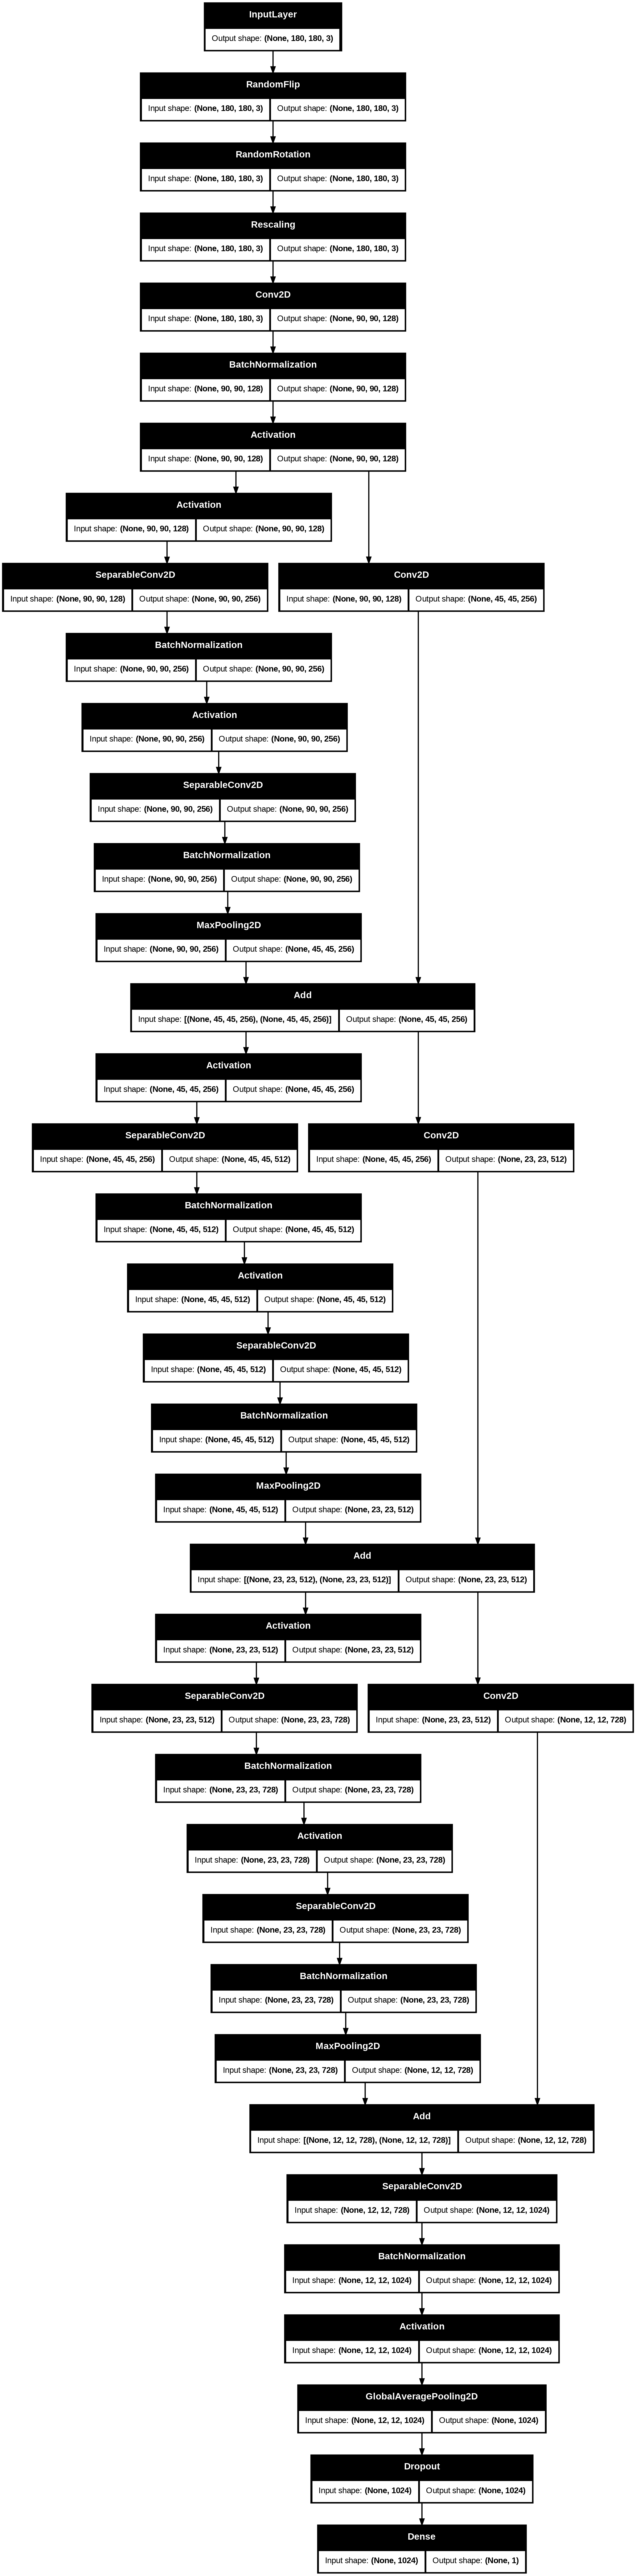

In [ ]:
keras.utils.plot_model(model, show_shapes = True)

이제 모델을 훈련시킨다.

In [ ]:
from tensorflow import data as tf_data

train = train.prefetch(tf_data.AUTOTUNE)
vaild = valid.prefetch(tf_data.AUTOTUNE)

In [ ]:
# 20분 소요

model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(train, epochs = 30, validation_data = valid)

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 50s 286ms/step - accuracy: 0.7348 - loss: 0.5366 - val_accuracy: 0.4934 - val_loss: 0.7276
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.8209 - loss: 0.4033 - val_accuracy: 0.4934 - val_loss: 0.7705
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.8582 - loss: 0.3294 - val_accuracy: 0.8501 - val_loss: 0.3493
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 282ms/step - accuracy: 0.8833 - loss: 0.2711 - val_accuracy: 0.6461 - val_loss: 1.2553
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 282ms/step - accuracy: 0.8972 - loss: 0.2417 - val_accuracy: 0.7260 - val_loss: 0.7177
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.9161 - loss: 0.2058 - val_accuracy: 0.8381 - val_loss: 0.4356
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 282ms/step - accuracy: 0.9186 - loss: 0.1986 - val_accuracy: 0.8573 - val_loss: 0.3808
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.9334 - loss: 0

훈련셋, 검증셋의 손실값, 정확도 그래프는 다음과 같다.

검증셋의 손실값이 계속 감소하는 것으로보아 훈련을 몇 번 더 해도 될 것같다.

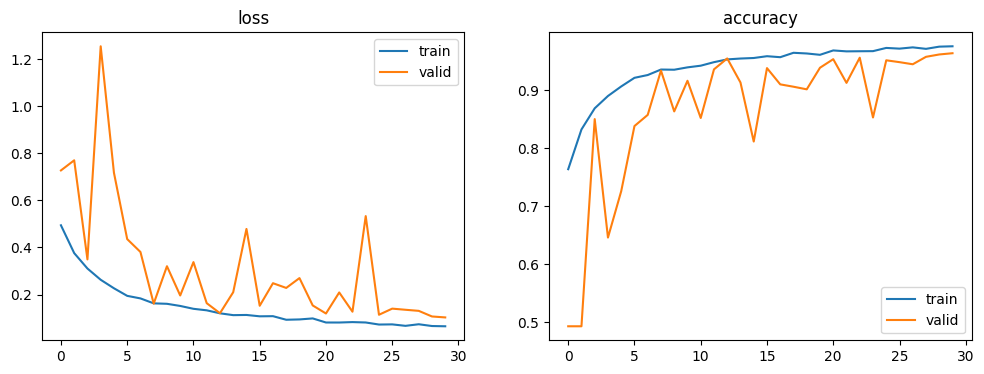

In [ ]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.title('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.title('accuracy')
plt.legend()

plt.show()

훈련 된 모델을 테스트해보자.

In [ ]:
images = []
predictions = []

for i in range(3):
  cat = keras.utils.load_img(f'/content/PetImages/Cat/{i + 1}.jpg', target_size = (180, 180))
  dog = keras.utils.load_img(f'/content/PetImages/Dog/{i + 5}.jpg', target_size = (180, 180))
  images.append(cat)
  images.append(dog)

  cat_array = keras.utils.img_to_array(cat)
  dog_array = keras.utils.img_to_array(dog)

  cat_array = keras.ops.expand_dims(cat_array, 0)
  dog_array = keras.ops.expand_dims(dog_array, 0)

  pred = model.predict(cat_array)
  predictions.append(pred)

  pred = model.predict(dog_array)
  predictions.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


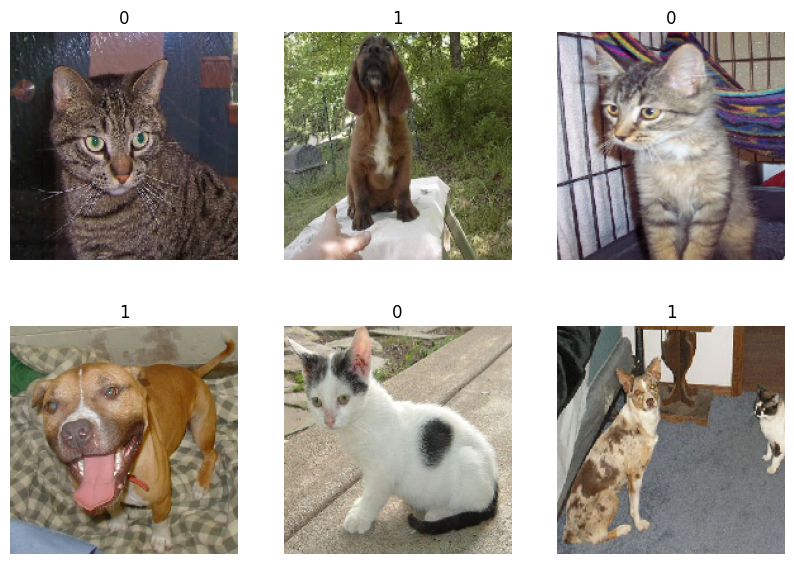

In [ ]:
plt.figure(figsize = (10, 7))

for i in range(6):
  plt.subplot(2, 3, i + 1)
  plt.imshow(images[i])
  plt.axis('off')
  plt.title(round(predictions[i][0][0]))

plt.show()